# Analyzing NYC High School Data

For this project we will be using data about New York City public schools.

One of the most controversial issues in the U.S. educational system is the efficacy of standardized tests, and whether they're unfair to certain groups. Given our prior knowledge of this topic, investigating the correlations between SAT scores and demographics might be an interesting angle to take. We could correlate SAT scores with factors like race, gender, income, and more.

The test consists of three sections, each of which has 800 possible points. The combined score is out of 2,400 possible points (while this number has changed a few times, the data set for our project is based on 2,400 total points). Organizations often rank high schools by their average SAT scores. The scores are also considered a measure of overall school district quality.

## *Step 1: Initial Exploration and Cleaning of Data*
### Finding Relavant Datasets
New York City makes its [data on high school SAT scores](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4) available online, as well as the [demographics for each high school](https://data.cityofnewyork.us/Education/2014-2015-DOE-High-School-Directory/n3p6-zve2).

Unfortunately, combining both of the data sets won't give us all of the demographic information we want to use. We'll need to supplement our data with other sources to do our full analysis.

The same website has several related data sets covering demographic information and test scores. Here are the links to all of the data sets we'll be using:

- [SAT scores by school](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4) - SAT scores for each high school in New York City
- [School attendance](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4) - Attendance information for each school in New York City
- [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) - Information on class size for each school
- [AP test results](https://data.cityofnewyork.us/Education/2010-AP-College-Board-School-Level-Results/itfs-ms3e) - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
- [Graduation outcomes](https://data.cityofnewyork.us/Education/2005-2010-Graduation-Outcomes-School-Level/vh2h-md7a) - The percentage of students who graduated, and other outcome information
- [Demographics](https://data.cityofnewyork.us/Education/2006-2012-School-Demographics-and-Accountability-S/ihfw-zy9j) - Demographic information for each school
- [School survey](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8) - Surveys of parents, teachers, and students at each school

All of these data sets are interrelated. We'll need to combine them into a single data set before we can find correlations.






### Finding Background Information
We can learn a few different things from these resources. For example:

- Only high school students take the SAT, so we'll want to focus on high schools.
- New York City is made up of five boroughs, which are essentially distinct regions.
- New York City schools fall within several different school districts, each of which can contains dozens of schools.
- Our data sets include several different types of schools. We'll need to clean them so that we can focus on high schools only.
- Each school in New York City has a unique code called a DBN, or district borough number.
- Aggregating data by district will allow us to use the district mapping data to plot district-by-district differences.


### Reading in the data
All necessary files have been renamed and made available in the repository.
 

In [1]:
import pandas as pd
data_files = [
    'ap_2010.csv',
    'class_size.csv',
    'demographics.csv',
    'graduation.csv',
    'hs_directory.csv',
    'sat_results.csv'
]
data = {}
for file in data_files:
    d = pd.read_csv(file)
    key_name = file.replace('.csv','')
    data[key_name] = d
    
data.keys()

dict_keys(['ap_2010', 'class_size', 'demographics', 'graduation', 'hs_directory', 'sat_results'])

### Exploring the SAT data
What we're mainly interested in is the SAT data set, which corresponds to the dictionary key _sat_results_. Let's explore _sat_results_.

In [2]:
data['sat_results'].head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384


We can make a few observations based on this output:

- The DBN appears to be a unique ID for each school.
- We can tell from the first few rows of names that we only have data about high schools.
- There's only a single row for each high school, so each DBN is unique in the SAT data.
- We may eventually want to combine the three columns that contain SAT scores -- SAT Critical Reading Avg. Score, SAT Math Avg. Score, and SAT Writing Avg. Score -- into a single column to make the scores easier to analyze.

### Exploring the remaining data

In [3]:
for key in data:
    print(data[key].head(), '\n')
    

      DBN                             SchoolName  AP Test Takers   \
0  01M448           UNIVERSITY NEIGHBORHOOD H.S.             39.0   
1  01M450                 EAST SIDE COMMUNITY HS             19.0   
2  01M515                    LOWER EASTSIDE PREP             24.0   
3  01M539         NEW EXPLORATIONS SCI,TECH,MATH            255.0   
4  02M296  High School of Hospitality Management              NaN   

   Total Exams Taken  Number of Exams with scores 3 4 or 5  
0               49.0                                  10.0  
1               21.0                                   NaN  
2               26.0                                  24.0  
3              377.0                                 191.0  
4                NaN                                   NaN   

   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto Clemente     0K   

We can make some observations based on the first few rows of each one.

- Each data set appears to either have a DBN column, or the information we need to create one. That means we can use a DBN column to combine the data sets. First we'll pinpoint matching rows from different data sets by looking for identical DBNs, then group all of their columns together in a single data set.
- Some fields look interesting for mapping -- particularly Location 1, which contains coordinates inside a larger string.
- Some of the data sets appear to contain multiple rows for each school (because the rows have duplicate DBN values). That means we’ll have to do some preprocessing to ensure that each DBN is unique within each data set. If we don't do this, we'll run into problems when we combine the data sets, because we might be merging two rows in one data set with one row in another data set.

### Reading in the Survey Data
The survey files _survey_all.txt_ and _survey_d75.txt_ are tab delimited and encoded with "Windows-1252" encoding.

In [4]:
all_survey = pd.read_csv('survey_all.txt', delimiter='\t', encoding='windows-1252')
d75_survey = pd.read_csv('survey_d75.txt', delimiter='\t', encoding='windows-1252')
survey = pd.concat([all_survey,d75_survey],axis=0)
survey.head()

,dbn,bn,schoolname,d75,studentssurveyed,highschool,schooltype,rr_s,rr_t,rr_p,...,s_q14_2,s_q14_3,s_q14_4,s_q14_5,s_q14_6,s_q14_7,s_q14_8,s_q14_9,s_q14_10,s_q14_11
0,01M015,M015,P.S. 015 Roberto Clemente,0,No,0.0,Elementary School,NaN,88,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01M019,M019,P.S. 019 Asher Levy,0,No,0.0,Elementary School,NaN,100,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01M020,M020,P.S. 020 Anna Silver,0,No,0.0,Elementary School,NaN,88,73,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01M034,M034,P.S. 034 Franklin D. Roosevelt,0,Yes,0.0,Elementary / Middle School,89.0,73,50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01M063,M063,P.S. 063 William McKinley,0,No,0.0,Elementary School,NaN,100,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There are two immediate facts that we can see in the data:

- There are over 2000 columns, nearly all of which we don't need. We'll have to filter the data to remove the unnecessary ones. Working with fewer columns will make it easier to print the dataframe out and find correlations within it.
- The survey data has a dbn column that we'll want to convert to uppercase (DBN). The conversion will make the column name consistent with the other data sets.

### Cleaning up the Surveys
First we must filter the columns to remove the ones we don't need. We can use the data dictionary (available in the respository) to determine which columns to use.

Before we filter columns out, we will copy the data from dbn to a new column DBN.

In [5]:
survey['DBN'] = survey['dbn']
useful_col = ['DBN', 'rr_s', 'rr_t', 'rr_p', 'N_s', 'N_t', 'N_p', 'saf_p_11', 'com_p_11', 'eng_p_11', 'aca_p_11', 'saf_t_11', 'com_t_11', 'eng_t_11', 'aca_t_11', 'saf_s_11', 'com_s_11', 'eng_s_11', 'aca_s_11', 'saf_tot_11', 'com_tot_11', 'eng_tot_11', 'aca_tot_11']
survey = survey[useful_col]
data['survey'] = survey
data['survey'].shape

(1702, 23)

### Inserting DBN fields
When we explored all of the data sets, we noticed that some of them, like _class_size_ and _hs_directory_, don't have a DBN column. _hs_directory_ does have a dbn column, though, so we can just rename it.

However, _class_size_ doesn't appear to have the column at all.


In [6]:
print(data['class_size'].head())
print(data['sat_results'].head())

   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto Clemente     0K          CTT   
2    1       M        M015  P.S. 015 Roberto Clemente     01       GEN ED   
3    1       M        M015  P.S. 015 Roberto Clemente     01          CTT   
4    1       M        M015  P.S. 015 Roberto Clemente     02       GEN ED   

  CORE SUBJECT (MS CORE and 9-12 ONLY) CORE COURSE (MS CORE and 9-12 ONLY)  \
0                                    -                                   -   
1                                    -                                   -   
2                                    -                                   -   
3                                    -                                   -   
4                                    -                                   -   

  SERVICE CATEGORY(K-9* ONLY)  NUMBER OF STUDENTS / SEATS FILLED  \


From looking at these rows, we can tell that the DBN in the _sat_results_ data is just a combination of the CSD and SCHOOL CODE columns in the _class_size_ data. The main difference is that the DBN is padded, so that the CSD portion of it always consists of two digits. That means we'll need to add a leading 0 to the CSD if the CSD is less than two digits long.

In [7]:
data['hs_directory']['DBN'] = data['hs_directory']['dbn']

def pad_csd(x):
    x = str(x)
    if len(x)==2:
        return x
    elif len(x)==1:
        return x.zfill(2)
    
data['class_size']['padded_csd'] = data['class_size']['CSD'].apply(pad_csd)
data['class_size']['DBN'] = data['class_size']['padded_csd'] + data['class_size']['SCHOOL CODE']
data['class_size'].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN,01,01M015
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN,01,01M015
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN,01,01M015


### Combining the SAT scores
We create a new column that totals up the SAT scores for the different sections of the exam. This will make it easier to correlate scores with demographic factors because we will be working with a single number, rather than 3 different ones.

Before we can generate this column, we need to convert the scores from object(string) data type to numeric data type.

In [8]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data['sat_results'][c] = pd.to_numeric(data['sat_results'][c], errors='coerce')
    
data['sat_results']['sat_score'] = data['sat_results'][cols].sum(axis=1)
data['sat_results']['sat_score']

0      1122.0
1      1172.0
2      1149.0
3      1174.0
4      1207.0
        ...  
473       0.0
474       0.0
475       0.0
476    1322.0
477    1097.0
Name: sat_score, Length: 478, dtype: float64

### Parsing Geographic Coordinates for Schools
We will parse the latitude and longitude coordinates for each school. This will enable us to map the schools and uncover any geographic patterns in the data. The coordinates are currently in the text field Location 1 in the _hs_directory_ data set.

In [9]:
data['hs_directory']['Location 1'].head()

0    50 Avenue\nX Brooklyn, NY 11223\n(40.589238098...
1    284 Baltic Street\nBrooklyn, NY 11201\n(40.685...
2    45 35 Van Dam Street\nLong Island City, NY 111...
3    509 West 129 Street\nNew York, NY 10027\n(40.8...
4    8 21 Bay 25 Street\nFar Rockaway, NY 11691\n(4...
Name: Location 1, dtype: object

We can observe that this field contains a lot of information we do not need. We want to extract the coordinates present in the parenthesis at the end of the field.

In [10]:
import re

coordinates = data['hs_directory']['Location 1'].str.extract("\((.+)\)")
coordinates = pd.Series(coordinates.iloc[:,0])
data['hs_directory']['lat'] = coordinates.str.split(',').str.get(0).str.strip()
data['hs_directory']['lon'] = coordinates.str.split(',').str.get(1).str.strip()

data['hs_directory']['lat'] = pd.to_numeric(data['hs_directory']['lat'], errors='coerce')
data['hs_directory']['lon'] = pd.to_numeric(data['hs_directory']['lon'], errors='coerce')


## *Step 2: Combining the Data*
In Step 1, we manipulated the data sets, and found the we could combine them all using the DBN column.
In this step, we will clean the data a bit more and then combine it.

We need to condense these data sets so that each value in the DBN column is unique. If not, we'll run into issues when it comes time to combine the data sets. While the main data set we want to analyze, _sat_results_, has unique DBN values for every high school in New York City, other data sets aren't as clean. A single row in the _sat_results_ data set may match multiple rows in the _class_size_ data set, for example. To resolve this, we'll condense the _class_size, graduation_ and _demographics_ data sets so that each DBN is unique.

### Condensing the Class Size Data Set

In [11]:
class_size = data['class_size']
class_size.head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN,01,01M015
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN,01,01M015
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN,01,01M015


We observe that the first few rows all pertain to the same school which is why the DBN appears more than once. It appears that each school has multiple values for GRADE, PROGRAM TYPE, CORE SUBJECT, and CORE COURSE.

In [12]:
print(class_size['GRADE '].value_counts(),'\n')
print(class_size['PROGRAM TYPE'].value_counts(),'\n')


09-12      10644
MS Core     4762
0K-09       1384
0K          1237
01          1185
02          1167
03          1143
04          1140
05          1086
06           846
07           778
08           735
09            20
Name: GRADE , dtype: int64 

GEN ED     14545
CTT         7460
SPEC ED     3653
G&T          469
Name: PROGRAM TYPE, dtype: int64 



- Since we are dealing with high schools, we are only concerned with the grades 9 through 12. That means we only want to pick rows where the value in the GRADE column is 09-12.
- Because GEN ED is the largest category by far, let's only select rows where PROGRAM TYPE is GEN ED.


In [13]:
class_size = class_size.loc[class_size['GRADE '] == '09-12']
class_size = class_size.loc[class_size['PROGRAM TYPE'] == 'GEN ED']
class_size.head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
225,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 9,-,63.0,3.0,21.0,19.0,25.0,STARS,NaN,01,01M292
226,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 10,-,79.0,3.0,26.3,24.0,31.0,STARS,NaN,01,01M292
227,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 11,-,38.0,2.0,19.0,16.0,22.0,STARS,NaN,01,01M292
228,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 12,-,69.0,3.0,23.0,13.0,30.0,STARS,NaN,01,01M292
229,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,MATH,Integrated Algebra,-,53.0,3.0,17.7,16.0,21.0,STARS,NaN,01,01M292


We see that DBN is still not unique. This is due to CORE COURSE and CORE SUBJECT columns.

We want our class size data to include every single class a school offers -- not just a subset of them. What we can do is take the average across all of the classes a school offers. This will give us unique DBN values, while also incorporating as much data as possible into the average.


In [14]:
import numpy as np
class_size = class_size.groupby('DBN').agg(np.mean).reset_index()
data['class_size'] = class_size
data['class_size'].head()

,DBN,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO
0,01M292,1,88.0000,4.000000,22.564286,18.50,26.571429,NaN
1,01M332,1,46.0000,2.000000,22.000000,21.00,23.500000,NaN
2,01M378,1,33.0000,1.000000,33.000000,33.00,33.000000,NaN
3,01M448,1,105.6875,4.750000,22.231250,18.25,27.062500,NaN
4,01M450,1,57.6000,2.733333,21.200000,19.40,22.866667,NaN


### Condensing the Demographics Data Set


In [15]:
demographics = data['demographics']
demographics.head()

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
0,01M015,P.S. 015 ROBERTO CLEMENTE,20052006,89.4,NaN,281,15,36,40,33,...,74,26.3,189,67.3,5,1.8,158.0,56.2,123.0,43.8
1,01M015,P.S. 015 ROBERTO CLEMENTE,20062007,89.4,NaN,243,15,29,39,38,...,68,28.0,153,63.0,4,1.6,140.0,57.6,103.0,42.4
2,01M015,P.S. 015 ROBERTO CLEMENTE,20072008,89.4,NaN,261,18,43,39,36,...,77,29.5,157,60.2,7,2.7,143.0,54.8,118.0,45.2
3,01M015,P.S. 015 ROBERTO CLEMENTE,20082009,89.4,NaN,252,17,37,44,32,...,75,29.8,149,59.1,7,2.8,149.0,59.1,103.0,40.9
4,01M015,P.S. 015 ROBERTO CLEMENTE,20092010,,96.5,208,16,40,28,32,...,67,32.2,118,56.7,6,2.9,124.0,59.6,84.0,40.4


In this case, the only column that prevents a given DBN from being unique is schoolyear. We only want to select rows where schoolyear is 20112012. This will give us the most recent year of data (according to our data set), and also match our SAT results data.

In [16]:
demographics = demographics.loc[demographics['schoolyear'] == 20112012]
data['demographics'] = demographics
data['demographics'].head()

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
6,01M015,P.S. 015 ROBERTO CLEMENTE,20112012,NaN,89.4,189,13,31,35,28,...,63,33.3,109,57.7,4,2.1,97.0,51.3,92.0,48.7
13,01M019,P.S. 019 ASHER LEVY,20112012,NaN,61.5,328,32,46,52,54,...,81,24.7,158,48.2,28,8.5,147.0,44.8,181.0,55.2
20,01M020,PS 020 ANNA SILVER,20112012,NaN,92.5,626,52,102,121,87,...,55,8.8,357,57.0,16,2.6,330.0,52.7,296.0,47.3
27,01M034,PS 034 FRANKLIN D ROOSEVELT,20112012,NaN,99.7,401,14,34,38,36,...,90,22.4,275,68.6,8,2.0,204.0,50.9,197.0,49.1
35,01M063,PS 063 WILLIAM MCKINLEY,20112012,NaN,78.9,176,18,20,30,21,...,41,23.3,110,62.5,15,8.5,97.0,55.1,79.0,44.9


### Condensing the Graduation Data Set

In [17]:
graduation = data['graduation']
graduation.head()

,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
0,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2003,5,s,NaN,s,NaN,NaN,...,s,NaN,NaN,s,NaN,NaN,s,NaN,s,NaN
1,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2004,55,37,67.3,17,30.9,45.9,...,17,30.9,45.9,20,36.4,54.1,15,27.3,3,5.5
2,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2005,64,43,67.2,27,42.2,62.8,...,27,42.2,62.8,16,25.0,37.2,9,14.1,9,14.1
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1,36,46.2,83.7,...,36,46.2,83.7,7,9.0,16.3,16,20.5,11,14.1
4,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006 Aug,78,44,56.4,37,47.4,84.1,...,37,47.4,84.1,7,9.0,15.9,15,19.2,11,14.1


In [18]:
print(graduation['Demographic'].unique())
print(graduation['Cohort'].value_counts())

['Total Cohort' 'Asian' 'Male' 'Black' 'English Language Learners'
 'Hispanic' 'White' 'English Proficient Students'
 'Special Education Students' 'General Education Students' 'Female']
2006 Aug    4131
2006        4130
2005        3963
2004        3708
2003        3432
2002        3095
2001        2637
Name: Cohort, dtype: int64


The Demographic and Cohort columns are what prevent DBN from being unique in the graduation data. A Cohort appears to refer to the year the data represents, and the Demographic appears to refer to a specific demographic group. In this case, we want to pick data from the most recent Cohort available, which is 2006. We also want data from the full cohort, so we'll only pick rows where Demographic is Total Cohort.

In [19]:
graduation = graduation.loc[graduation['Cohort'] == '2006']
graduation = graduation.loc[graduation['Demographic'] == 'Total Cohort']
data['graduation'] = graduation

### Converting AP Test Scores
The only remaining thing to do is convert the Advanced Placement (AP) test scores from strings to numeric values.
AP exams have a 1 to 5 scale; 3 or higher is a passing score. 

Many high school students take AP exams -- particularly those who attend academically challenging institutions. AP exams are much more rare in schools that lack funding or academic rigor.

It will be interesting to find out whether AP exam scores are correlated with SAT scores across high schools. To determine this, we'll need to convert the AP exam scores in the ap_2010 data set to numeric values first.

We need to convert three columns:
- AP Test Takers
- Total Exams Taken
- Number of Exams with scores 3 4 or 5



In [20]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']
for c in cols:
    data['ap_2010'][c] = pd.to_numeric(data['ap_2010'][c], errors='coerce')
data['ap_2010'].dtypes

DBN                                      object
SchoolName                               object
AP Test Takers                          float64
Total Exams Taken                       float64
Number of Exams with scores 3 4 or 5    float64
dtype: object

### Left Inner Join
Both the _ap_2010_ and the _graduation_ data sets have many missing DBN values, so we'll use a left join when we merge the _sat_results_ data set with them. Because we're using a left join, our final dataframe will have all of the same DBN values as the original _sat_results_ dataframe.

After performing the left joins, we still have to merge _class_size, demographics, survey,_ and _hs_directory_ into combined. Because these files contain information that's more valuable to our analysis and also have fewer missing DBN values, we'll use the inner join type.

In [21]:
combined = data['sat_results']
leftj = ['ap_2010', 'graduation']
innerj = ['class_size', 'demographics', 'survey', 'hs_directory']

for d in leftj:
    combined = combined.merge(data[d], on='DBN', how='left')
print(combined.shape)

for d in innerj:
    combined = combined.merge(data[d], on='DBN', how='inner')
print(combined.shape)

(479, 33)
(363, 165)


In [22]:
data['hs_directory'].columns

Index(['dbn', 'school_name', 'borough', 'building_code', 'phone_number',
       'fax_number', 'grade_span_min', 'grade_span_max', 'expgrade_span_min',
       'expgrade_span_max', 'bus', 'subway', 'primary_address_line_1', 'city',
       'state_code', 'postcode', 'website', 'total_students', 'campus_name',
       'school_type', 'overview_paragraph', 'program_highlights',
       'language_classes', 'advancedplacement_courses', 'online_ap_courses',
       'online_language_courses', 'extracurricular_activities',
       'psal_sports_boys', 'psal_sports_girls', 'psal_sports_coed',
       'school_sports', 'partner_cbo', 'partner_hospital', 'partner_highered',
       'partner_cultural', 'partner_nonprofit', 'partner_corporate',
       'partner_financial', 'partner_other', 'addtl_info1', 'addtl_info2',
       'start_time', 'end_time', 'se_services', 'ell_programs',
       'school_accessibility_description', 'number_programs', 'priority01',
       'priority02', 'priority03', 'priority04', 'prior

We notice that  the inner joins resulted in 116 fewer rows in _sat_results_. This is because pandas could not find the DBN values that existed in _sat_results_ in the other data sets. While this is worth investigating, we're currently looking for high-level correlations, so we don't need to dive into which DBNs are missing.

Also, there are several columns with missing values.

### Filling in Missing Values
We fill the missing values with the means of all columns, and with 0 in case a mean does not exist.

In [23]:
means = combined.mean()
combined = combined.fillna(means)
combined = combined.fillna(0)
combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority10,Location 1,Community Board,Council District,Census Tract,BIN,BBL,NTA,lat,lon
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,...,0.0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",3.0,1.0,201.0,1003223.0,1.002690e+09,Lower East Side ...,40.713764,-73.985260
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0.0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",3.0,1.0,202.0,1003214.0,1.002590e+09,Lower East Side ...,40.712332,-73.984797
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.000000,21.000000,...,0.0,"420 East 12 Street\nNew York, NY 10009\n(40.72...",3.0,2.0,34.0,1005974.0,1.004390e+09,East Village ...,40.729783,-73.983041
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,0,129.028846,197.038462,...,0.0,"145 Stanton Street\nNew York, NY 10002\n(40.72...",3.0,1.0,3001.0,1004323.0,1.003540e+09,Chinatown ...,40.720569,-73.985673
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.000000,377.000000,...,0.0,"111 Columbia Street\nNew York, NY 10002\n(40.7...",3.0,2.0,2201.0,1004070.0,1.003350e+09,Lower East Side ...,40.718725,-73.979426


### Adding a School District Column for Mapping
We've finished cleaning and combining our data! We now have a clean data set on which we can base our analysis. Mapping the statistics out on a school district level might be an interesting way to analyze them. Adding a column to the data set that specifies the school district will help us accomplish this.

The school district is just the first two characters of the DBN. We can apply a function over the DBN column of combined that pulls out the first two letters.

In [24]:
combined['school_dist'] = combined['DBN'].str[0:2]
combined['school_dist'].head()

0    01
1    01
2    01
3    01
4    01
Name: school_dist, dtype: object

## *Step 3: Analyzing and Visualizing the Data*
In this step, we will discover correlations, create plots, and then make maps. 

In [25]:
correlations = combined.corr()
correlations = correlations['sat_score']
correlations.sort_values(ascending=False)

sat_score                          1.000000
SAT Writing Avg. Score             0.472854
SAT Critical Reading Avg. Score    0.472399
SAT Math Avg. Score                0.465612
SIZE OF LARGEST CLASS              0.378741
                                     ...   
expgrade_span_min                       NaN
expgrade_span_max                       NaN
priority08                              NaN
priority09                              NaN
priority10                              NaN
Name: sat_score, Length: 85, dtype: float64

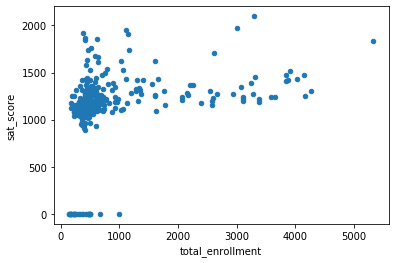

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
combined.plot.scatter(x='total_enrollment', y='sat_score')
plt.show()

Judging from the plot we just created, it doesn't appear that there's an extremely strong correlation between _sat_score_ and _total_enrollment_. If there was a very strong correlation, we'd expect all of the points to line up. Instead, there's a large cluster of schools, and then a few others going off in three different directions.

However, there's an interesting cluster of points at the bottom left where _total_enrollment_ and _sat_score_ are both low. This cluster may be what's making the r value so high. It's worth extracting the names of the schools in this cluster so we can research them further.

In [27]:
low_enrollment = combined.loc[combined['total_enrollment'] <1000]
low_enrollment = combined.loc[combined['sat_score']<1000]
print(low_enrollment['School Name'])

18                                         0
19                                         0
20                                         0
31                                         0
32                                         0
33                                         0
56                                         0
57                                         0
59                                         0
74                                         0
83                                         0
91       INTERNATIONAL COMMUNITY HIGH SCHOOL
103                                        0
109                                        0
111                                        0
123                                        0
125                                        0
126          BRONX INTERNATIONAL HIGH SCHOOL
139    KINGSBRIDGE INTERNATIONAL HIGH SCHOOL
141    INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176                                        0
177                                        0
178       

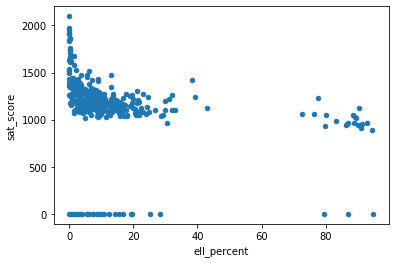

In [28]:
combined.plot.scatter(x='ell_percent', y='sat_score')
plt.show()

It looks like _ell_percent_ correlates with _sat_score_ more strongly, because the scatterplot is more linear. However, there's still the cluster of schools that have very high _ell_percent_ values and low _sat_score_ values. This cluster represents the same group of international high schools we investigated earlier.

In order to explore this relationship, we'll want to map out _ell_percent_ by school district. The map will show us which areas of the city have a lot of English language learners.

/home/bhavya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if __name__ == '__main__':
/home/bhavya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  


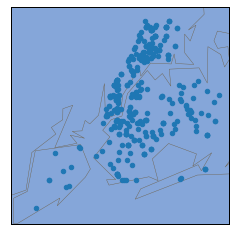

In [29]:
from mpl_toolkits.basemap import Basemap

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = combined["lon"].tolist()
latitudes = combined["lat"].tolist()
m.scatter(longitudes, latitudes, s=20, zorder=2, latlon=True)
plt.show()

From the map on the previous screen, we can see that school density is highest in Manhattan (the top of the map), and lower in Brooklyn, the Bronx, Queens, and Staten Island.

/home/bhavya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if __name__ == '__main__':
/home/bhavya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  


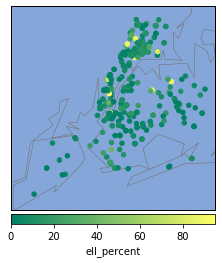

In [38]:
from mpl_toolkits.basemap import Basemap

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = combined["lon"].tolist()
latitudes = combined["lat"].tolist()
m.scatter(longitudes, latitudes, s=20, zorder=2, latlon=True, c=combined["ell_percent"], cmap="summer")
m.colorbar(location='bottom', label='ell_percent')
plt.show()

Unfortunately, due to the number of schools, it's hard to interpret the map we made on the last screen. It looks like uptown Manhattan and parts of Queens have a higher _ell_percent_, but we can't be sure. One way to make very granular statistics easier to read is to aggregate them. In this case, we can aggregate by district, which will enable us to plot _ell_percent_ district-by-district instead of school-by-school.

In [36]:
districts = combined.groupby("school_dist").agg(np.mean)
districts.reset_index(inplace=True)
districts.head()

,school_dist,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,Total Grads - % of cohort,...,priority08,priority09,priority10,Community Board,Council District,Census Tract,BIN,BBL,lat,lon
0,01,441.833333,473.333333,439.333333,1354.500000,116.681090,173.019231,135.800000,93.500000,71.333333,...,0.0,0.0,0.0,3.000000,1.500000,1106.833333,1.004144e+06,1.003302e+09,40.719022,-73.982377
1,02,426.619092,444.186256,424.832836,1142.708333,128.908454,201.516827,157.495833,158.647849,75.453574,...,0.0,0.0,0.0,4.204005,2.963296,1132.479744,1.103862e+06,1.070438e+09,40.739699,-73.991386
2,03,428.529851,437.997512,426.915672,987.583333,156.183494,244.522436,193.087500,183.384409,74.029937,...,0.0,0.0,0.0,7.500000,6.500000,166.666667,1.034931e+06,1.012833e+09,40.781574,-73.977370
3,04,402.142857,416.285714,405.714286,1224.142857,129.016484,183.879121,151.035714,113.857143,76.257143,...,0.0,0.0,0.0,11.000000,8.000000,2637.000000,1.055874e+06,1.016681e+09,40.793449,-73.943215
4,05,427.159915,438.236674,419.666098,1110.285714,85.722527,115.725275,142.464286,143.677419,75.200881,...,0.0,0.0,0.0,9.428571,8.142857,9372.571429,1.063080e+06,1.019721e+09,40.817077,-73.949251


/home/bhavya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if __name__ == '__main__':
/home/bhavya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  


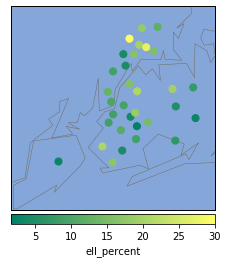

In [39]:
from mpl_toolkits.basemap import Basemap

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts["ell_percent"], cmap="summer")
m.colorbar(location='bottom', label='ell_percent')

plt.show()